In [1]:
from gillespy2.core import Model, Species, Reaction, Parameter
import numpy as np

In [2]:
# Go to dashboard url to inspect processes
from dask.distributed import Client, progress
client = Client(threads_per_worker=2, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:49853 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 2 Memory: 17.18 GB


In [3]:
class VilarOscillator(Model):
    def __init__(self, parameter_values=None):
        # initialize Model
        Model.__init__(self, name="VilarOscillator")

        # parameters
        alpha_a = Parameter(name='alpha_a', expression=50.0)
        alpha_a_prime = Parameter(name='alpha_a_prime', expression=500.0)
        alpha_r = Parameter(name='alpha_r', expression=0.01)
        alpha_r_prime = Parameter(name='alpha_r_prime', expression=50.0)
        beta_a = Parameter(name='beta_a', expression=50.0)
        beta_r = Parameter(name='beta_r', expression=5.0)
        delta_ma = Parameter(name='delta_ma', expression=10.0)
        delta_mr = Parameter(name='delta_mr', expression=0.5)
        delta_a = Parameter(name='delta_a', expression=1.0)
        delta_r = Parameter(name='delta_r', expression=0.2)
        gamma_a = Parameter(name='gamma_a', expression=1.0)
        gamma_r = Parameter(name='gamma_r', expression=1.0)
        gamma_c = Parameter(name='gamma_c', expression=2.0)
        Theta_a = Parameter(name='Theta_a', expression=50.0)
        Theta_r = Parameter(name='Theta_r', expression=100.0)

        self.add_parameter([alpha_a, alpha_a_prime, alpha_r, alpha_r_prime, beta_a, beta_r, delta_ma, delta_mr,
                            delta_a, delta_r, gamma_a, gamma_r, gamma_c, Theta_a, Theta_r])

        # Species
        Da = Species(name='Da', initial_value=1)
        Da_prime = Species(name='Da_prime', initial_value=0)
        Ma = Species(name='Ma', initial_value=0)
        Dr = Species(name='Dr', initial_value=1)
        Dr_prime = Species(name='Dr_prime', initial_value=0)
        Mr = Species(name='Mr', initial_value=0)
        C = Species(name='C', initial_value=10)
        A = Species(name='A', initial_value=10)
        R = Species(name='R', initial_value=10)

        self.add_species([Da, Da_prime, Ma, Dr, Dr_prime, Mr, C, A, R])

        # reactions
        s_Da = Reaction(name="s_Da", reactants={Da_prime: 1}, products={Da: 1}, rate=Theta_a)
        s_Da_prime = Reaction(name="s_Da_prime", reactants={Da: 1, A: 1}, products={Da_prime: 1},
                                        rate=gamma_a)
        s_Dr = Reaction(name="s_Dr", reactants={Dr_prime: 1}, products={Dr: 1}, rate=Theta_r)
        s_Dr_prime = Reaction(name="s_Dr_prime", reactants={Dr: 1, A: 1}, products={Dr_prime: 1},
                                        rate=gamma_r)
        s_Ma1 = Reaction(name="s_Ma1", reactants={Da_prime: 1}, products={Da_prime: 1, Ma: 1},
                                   rate=alpha_a_prime)
        s_Ma2 = Reaction(name="s_Ma2", reactants={Da: 1}, products={Da: 1, Ma: 1}, rate=alpha_a)
        a_Ma = Reaction(name="a_Ma", reactants={Ma: 1}, products={}, rate=delta_ma)
        s_A1 = Reaction(name="s_A1", reactants={Ma: 1}, products={A: 1, Ma: 1}, rate=beta_a)
        s_A2 = Reaction(name="S_A2", reactants={Da_prime: 1}, products={Da_prime: 1, A: 1}, rate=Theta_a)
        s_A3 = Reaction(name="S_A3", reactants={Dr_prime: 1}, products={Dr_prime: 1, A: 1}, rate=Theta_a)
        a_A = Reaction(name="a_A", reactants={A: 1}, products={}, rate=gamma_c)
        s_C = Reaction(name="s_C", reactants={A: 1, R: 1}, products={C: 1}, rate=gamma_c)
        S_Mr1 = Reaction(name="S_Mr1", reactants={Dr_prime: 1}, products={Dr_prime: 1, Mr: 1},
                                   rate=alpha_r_prime)
        S_Mr2 = Reaction(name="S_Mr2", reactants={Dr: 1}, products={Dr: 1, Mr: 1}, rate=alpha_r)
        a_Mr = Reaction(name="a_Mr", reactants={Mr: 1}, products={}, rate=delta_mr)
        s_R1 = Reaction(name="s_R1", reactants={Mr: 1}, products={Mr: 1, R: 1}, rate=beta_r)
        a_R = Reaction(name="a_R", reactants={R: 1}, products={}, rate=delta_r)
        s_r2 = Reaction(name="s_r2", reactants={C: 1}, products={R: 1}, rate=delta_a)

        self.add_reaction([s_Da, s_Da_prime, s_Dr, s_Dr_prime, s_Ma1, s_Ma2, a_Ma, s_A1, s_A2, s_A3, a_A, s_C,
                           S_Mr1, S_Mr2, a_Mr, s_R1, a_R, s_r2])

        self.timespan(np.linspace(0, 200, 201))

In [4]:
from gillespy2.solvers.numpy.basic_tau_leaping_solver import BasicTauLeapingSolver
model = VilarOscillator()

In [10]:
# Example using seeds

from random import random
num_trajectories = 5
seeds = [ int(random()*100) for i in range(num_trajectories) ]

futures_with_seeds = []

for seed in seeds:
    future = client.submit(model.run, pure=False, seed=seed)
    futures_with_seeds.append(future)

futures_with_seeds

[<Future: status: pending, key: run-ceb13c27-2d0c-44c8-978c-c5312a4ac3d0>,
 <Future: status: pending, key: run-90d8739e-78a9-417e-8e75-9cbf4a5525c9>,
 <Future: status: pending, key: run-7f8b5e4e-3b74-4513-b4c9-2b80d49f55d0>,
 <Future: status: pending, key: run-54454a0a-d675-4b59-8141-866956b407ef>,
 <Future: status: pending, key: run-cbabf1f2-2136-454a-9949-b59b0414f7ac>]

In [11]:
# Without seeds
futures_without_seeds = []

for i in range(0, 5):
    # Use pure=False or else dask will re-use the same run call
    future = client.submit(model.run, pure=False)
    futures_without_seeds.append(future)
    
futures_without_seeds

[<Future: status: pending, key: run-ac160207-d195-42f3-8cef-6152e203326c>,
 <Future: status: pending, key: run-ce57eda0-9709-44e3-b163-249037dfbd6a>,
 <Future: status: pending, key: run-8a86c486-f130-44cd-a528-689d1519a5c0>,
 <Future: status: pending, key: run-e6f2e87e-4cee-4f41-8309-97046e107740>,
 <Future: status: pending, key: run-6761aae2-bdca-486b-8a61-e33eb1082118>]

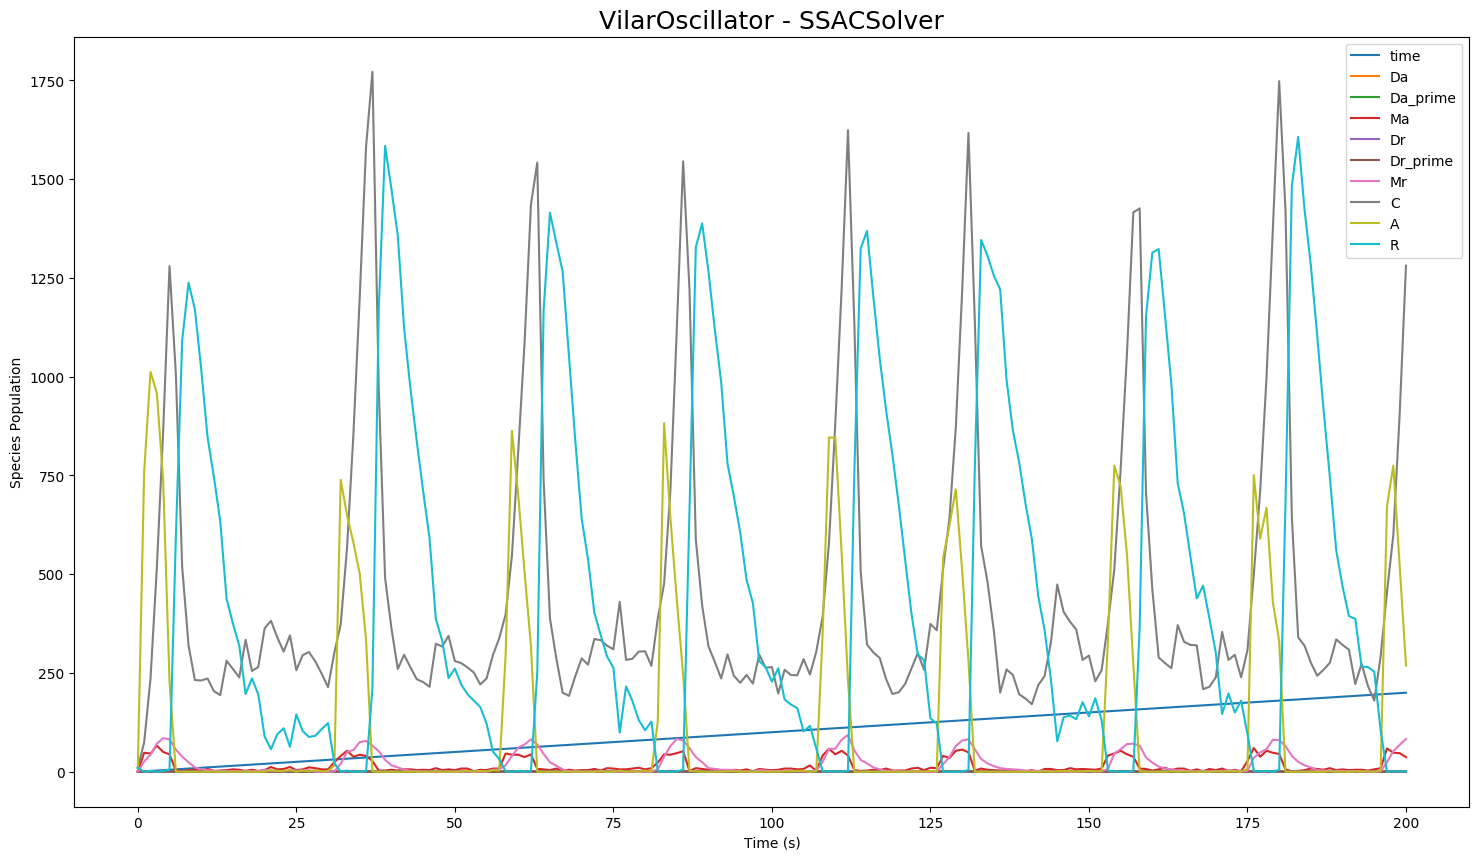

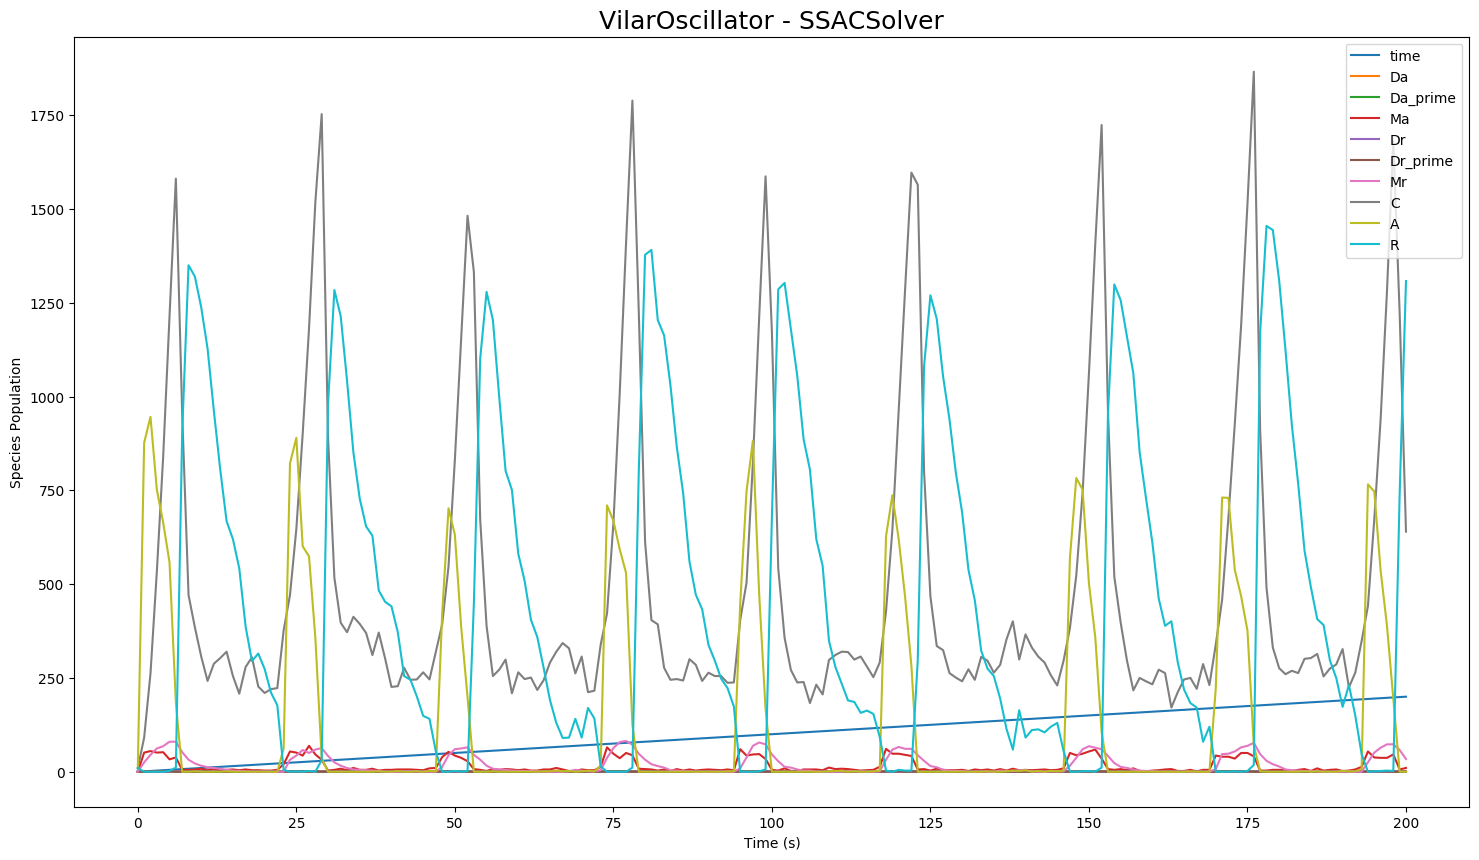

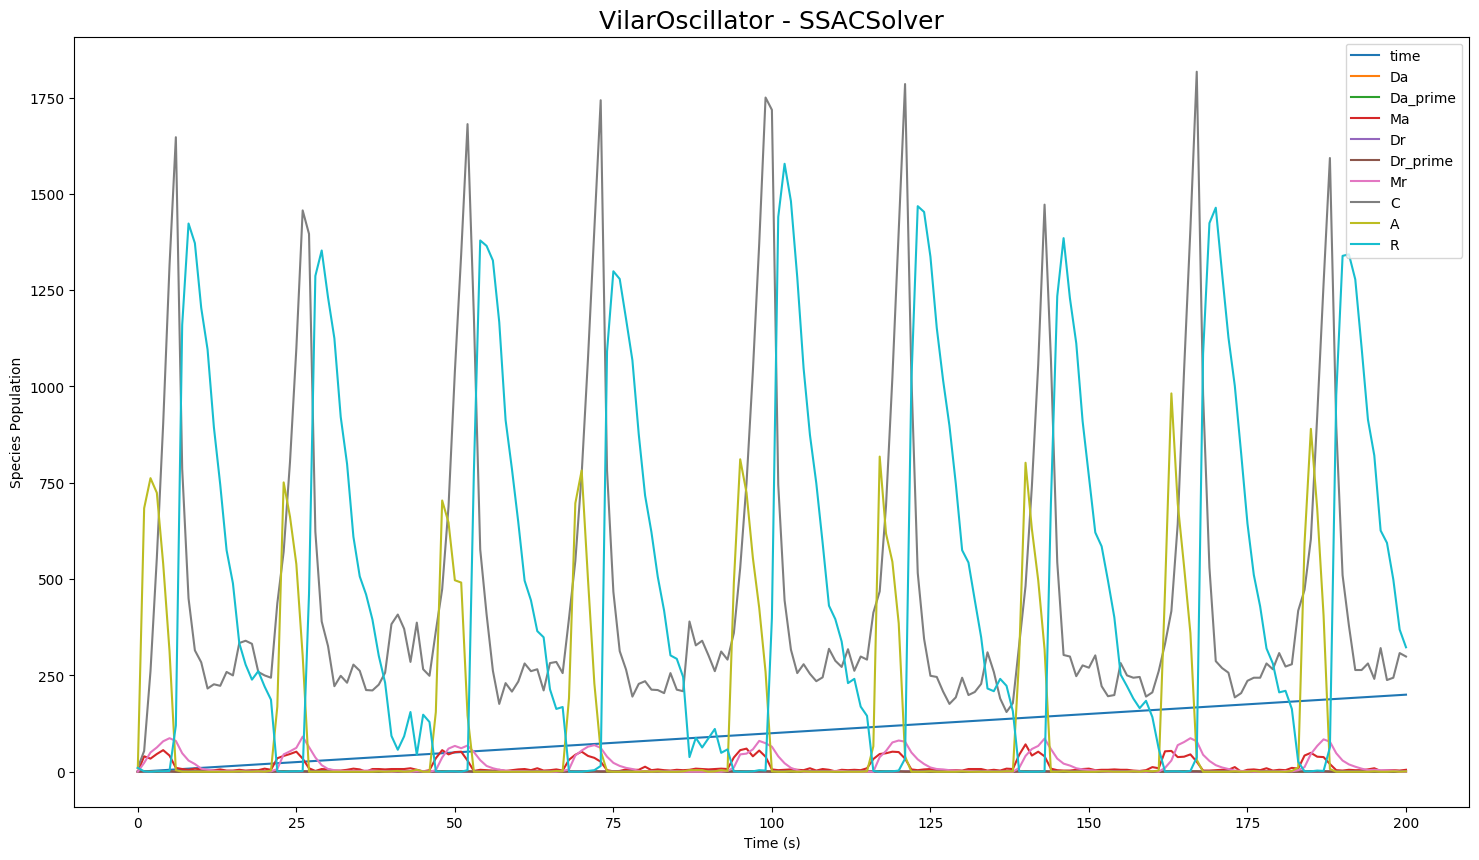

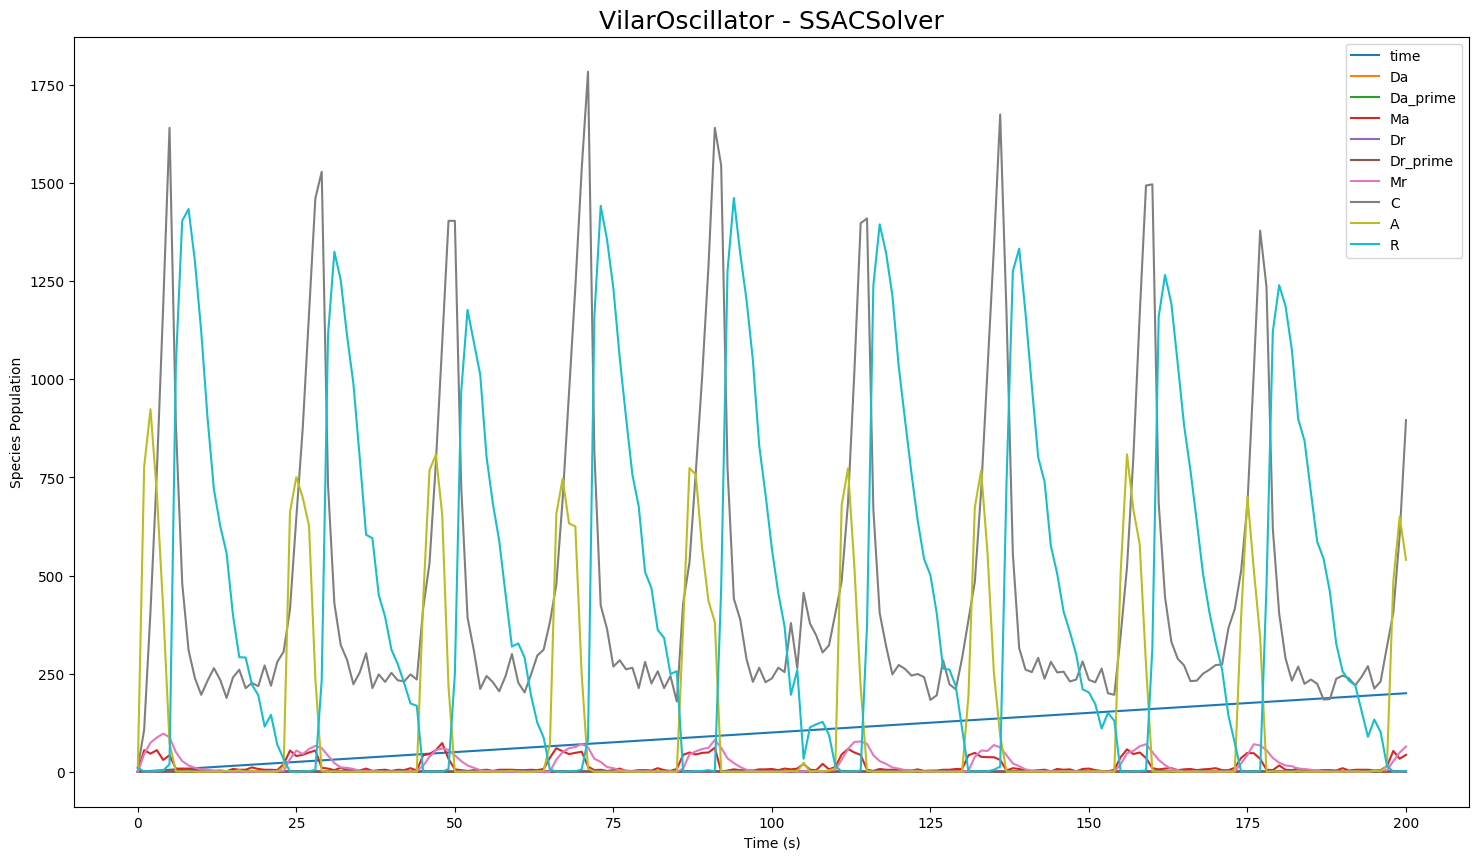

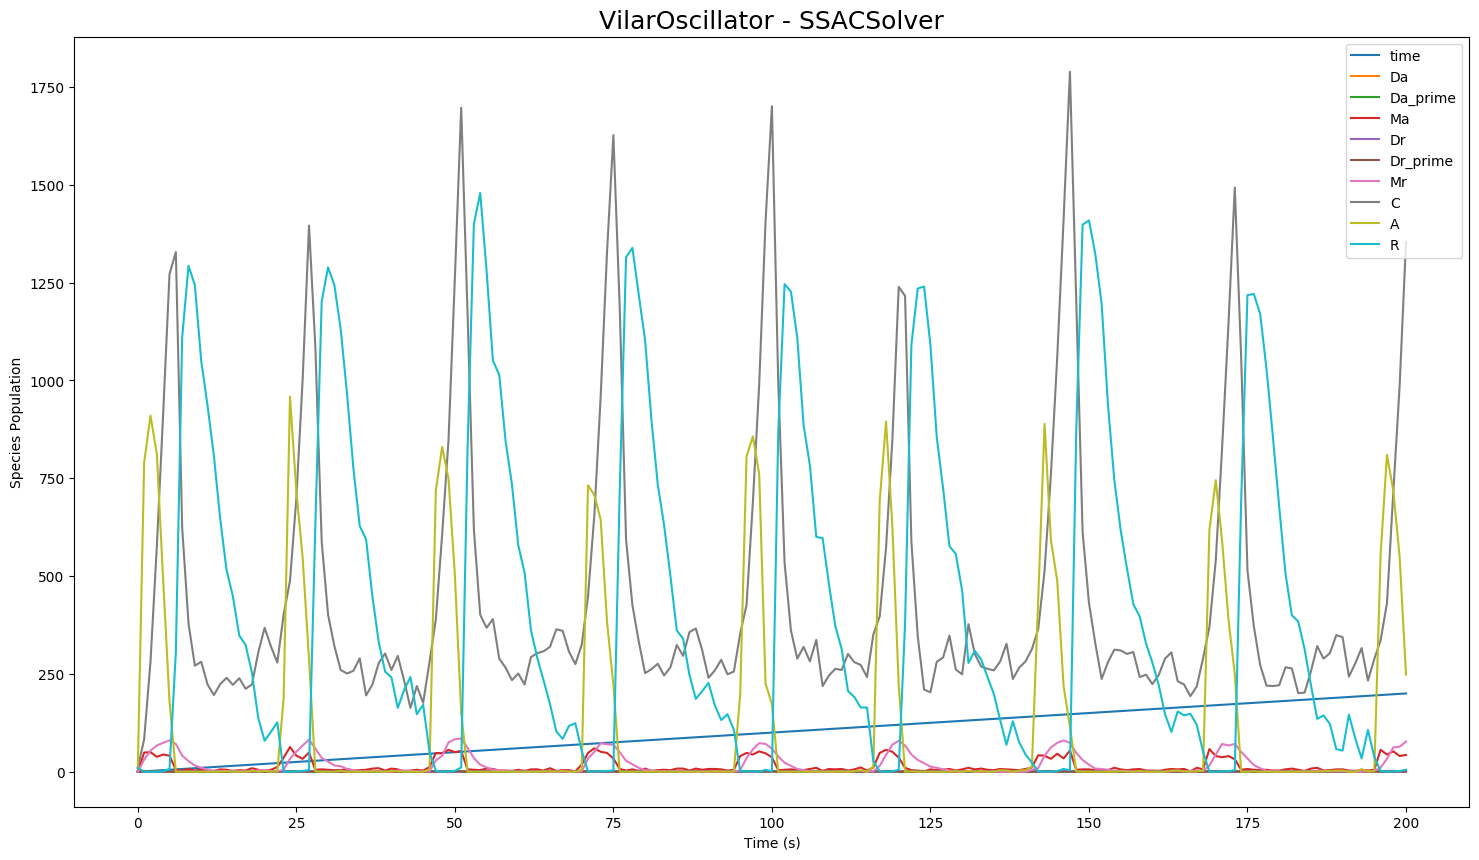

In [17]:
# Plot the first 5 trajectories for seeded simulations
for f in futures_with_seeds[:5]:
    result = f.result()
    result.plot()